# Loading Data

In [1]:
# External Dependencies: nltk, transformers, np

import nltk
nltk.download('punkt')
import csv
import json
import sys
from transformers import RobertaTokenizer
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to C:\Users\Harold
[nltk_data]     Rubio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Code base for function provided by: https://github.com/NLPrinceton/SARC
def extract_post_sub(pol=True):
    SARC_MAIN = 'main/'
    SARC_POL = 'pol/'

    if pol:
        SARC = SARC_POL
    else:
        SARC = SARC_MAIN

    train_file = SARC+'train-balanced.csv'
    train_unbal = SARC + 'train-unbalanced.csv'
    test_file = SARC+'test-balanced.csv'
    test_unbal = SARC + 'test-unbalanced.csv'
    comment_file = SARC+'comments.json'

    train_data = {}
    train_data['posts'] = []
    test_data = {}
    test_data['posts'] = []

    print('Load SARC data')
    with open(comment_file, 'r') as f:
        comments = json.load(f)

    counter=0
    print('loading train bal ids')
    # Handle training data first
    train_bal_ids = {}
    with open(train_file, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            counter += 1
            curr_ids = []
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')

            # Add these IDs to the list
            curr_ids.extend(ancestors)
            curr_ids.extend(responses)
            for curr_id in curr_ids:
                train_bal_ids[curr_id] = 1
            if counter % 1000 == 0:
                print(f'num rows processed {counter}')
    #print('done with train ids')
    # Find posts in unbal not in bal
    counter=0
    print('loading train unbal ids')
    with open(train_unbal, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            counter += 1
            # Get possible post IDS
            post_ids = []
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')
            post_ids.extend(ancestors)
            post_ids.extend(responses)
            for post_id in post_ids:
                # Skip ids found in balanced
                if post_id in train_bal_ids:
                    continue
                # Construct entry and add to dictionary
                post_text = comments[post_id]['text']
                subreddit = comments[post_id]['subreddit']
                if subreddit == 'reddit.com':
                    continue
                entry = {'text' : post_text, 'subreddit': subreddit}
                train_data['posts'].append(entry)
            if counter % 1000 == 0:
                print(f'num rows processed {counter}')
    
    del train_bal_ids

    # Handle test data now
    test_bal_ids = {}
    counter=0
    print('loading test bal ids')
    with open(test_file, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            counter += 1
            curr_ids = []
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')

            # Add these IDs to the list
            curr_ids.extend(ancestors)
            curr_ids.extend(responses)
            for curr_id in curr_ids:
                test_bal_ids[curr_id] = 1
            if counter % 1000 == 0:
                print(f'num rows processed {counter}')
    # Find posts in unbal not in bal
    counter=0
    print('loading test unbal ids')
    with open(test_unbal, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            counter += 1
            # Get possible post IDS
            post_ids = []
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')
            post_ids.extend(ancestors)
            post_ids.extend(responses)
            for post_id in post_ids:
                # Skip ids found in balanced
                if post_id in test_bal_ids:
                    continue
                # Construct entry and add to dictionary
                post_text = comments[post_id]['text']
                subreddit = comments[post_id]['subreddit']
                if subreddit == 'reddit.com':
                    continue
                entry = {'text' : post_text, 'subreddit': subreddit}
                test_data['posts'].append(entry)
            if counter % 1000 == 0:
                print(f'num rows processed {counter}')

    return train_data, test_data

In [36]:
# Code base for function provided by: https://github.com/NLPrinceton/SARC
def parse_data(pol=True, lower=True):
    SARC_MAIN = 'main/'
    SARC_POL = 'pol/'

    if pol:
        SARC = SARC_POL
    else:
        SARC = SARC_MAIN

    train_file = SARC+'train-balanced.csv'
    test_file = SARC+'test-balanced.csv'
    comment_file = SARC+'comments.json'

    print('Load SARC data')
    with open(comment_file, 'r') as f:
        comments = json.load(f)

    train_docs = {'ancestors': [], 'responses': []}
    train_stats = {'ancestors': [], 'responses': []}
    train_labels = []
    with open(train_file, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')
            labels = row[2].split(' ')

            if lower:
                # For each ancestor comment
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    # Add single comment to list of comments
                    comment_list.append(comments[r]['text'].lower())
                    # Create dictionary of additional information about comment
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    # Add dictionary to list
                    entry_stats.append(comment_entry)
                train_docs['ancestors'].append(comment_list)
                train_stats['ancestors'].append(entry_stats)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['responses'].append(comment_list)
                train_stats['responses'].append(entry_stats)
            else:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['ancestors'].append(comment_list)
                train_stats['ancestors'].append(entry_stats)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['responses'].append(comment_list)
                train_stats['responses'].append(entry_stats)

            train_labels.append(labels)

    test_docs = {'ancestors': [], 'responses': []}
    test_stats = {'ancestors': [], 'responses': []}
    test_labels = []
    with open(test_file, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            #print('next test entry')
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')
            labels = row[2].split(' ')

            if lower:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['ancestors'].append(entry_stats)
                test_docs['ancestors'].append(comment_list)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['responses'].append(entry_stats)
                test_docs['responses'].append(comment_list)
            else:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['ancestors'].append(entry_stats)
                test_docs['ancestors'].append(comment_list)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['responses'].append(entry_stats)
                test_docs['responses'].append(comment_list)

            test_labels.append(labels)
    return train_docs, train_labels, test_docs, test_labels, train_stats, test_stats

In [37]:
is_pol = False
train_docs, train_labels, test_docs, test_labels, train_stats, test_stats = parse_data(pol=is_pol)

Load SARC data


# Setting up helper functions

In [38]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_resp = train_docs['responses']
train_resp_stats = train_stats['responses']
train_resp_labels = train_labels

test_resp = test_docs['responses']
test_resp_stats = test_stats['responses']
test_resp_labels = test_labels

In [9]:
def write_to_file_ntlk(data_file, data, labels, stats=None):
    counter = 0
    with open(data_file, 'w') as f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                counter += 1
                toks = nltk.tokenize.word_tokenize(data[i][j])
                label = labels[i][j]
                f.write(str(counter) + " " + str(label) + " " + " ".join(toks) + '\n')

def write_to_file_rob(data_file, data, labels, stats=None):
    counter = 0
    with open(data_file, 'w') as f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                counter += 1
                label = labels[i][j]
                toks = tokenizer(data[i][j])['input_ids']
                f.write(str(counter) + " " + str(label) + " " + " ".join([str(j) for j in toks]) + '\n')
def write_to_file_ntlk_user(data_file, data, labels, stats=None):
    counter = 0
    with open(data_file, 'w') as f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                counter += 1
                user = stats[i][j]['author']
                label = labels[i][j]
                toks = data[i][j]
                f.write(str(counter) + " " + str(label) + " " + user + " " + toks + '\n')

# Extracting Single-Post Sequences (NLTK)

In [6]:
if is_pol:
    write_to_file_ntlk('train_pol.txt', train_resp, train_resp_labels)
    write_to_file_ntlk('test_pol.txt', test_resp, test_resp_labels)
else:
    write_to_file_ntlk('train_main.txt', train_resp, train_resp_labels)
    write_to_file_ntlk('test_main.txt', test_resp, test_resp_labels)

# Extracting Single-Post Sequences (RoBERTa)

In [7]:
if is_pol:
    write_to_file_rob('train_pol_rob.txt', train_resp, train_resp_labels)
    write_to_file_rob('test_pol_rob.txt', test_resp, test_resp_labels)
else:
    write_to_file_rob('train_main_rob.txt', train_resp, train_resp_labels)
    write_to_file_rob('test_main_rob.txt', test_resp, test_resp_labels)

# Extracting Single-Post User-Labeled Sequences (NLTK)

In [10]:
if is_pol:
    write_to_file_ntlk_user('train_pol_users.txt', train_resp, train_resp_labels, stats=train_resp_stats)
    write_to_file_ntlk_user('test_pol_users.txt', test_resp, test_resp_labels, stats=test_resp_stats)
else:
    write_to_file_ntlk_user('train_main_users.txt', train_resp, train_resp_labels, stats=train_resp_stats)
    write_to_file_ntlk_user('test_main_users.txt', test_resp, test_resp_labels, stats=test_resp_stats)

# Build GLoVE

In [11]:
embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Looking at OOV words/tokens

In [9]:
from collections import defaultdict
from collections import Counter

In [12]:
c = Counter()
train_anc = train_docs['ancestors']
train_resp = train_docs['responses']
test_anc = test_docs['ancestors']
test_resp = test_docs['responses']
for k in train_docs.keys():
    for i in range(len(train_docs[k])):
        for j in range(len(train_docs[k][i])):
            c.update(nltk.tokenize.word_tokenize(train_docs[k][i][j]))
            
    for i in range(len(test_docs[k])):
        for j in range(len(test_docs[k][i])):
            c.update(nltk.tokenize.word_tokenize(test_docs[k][i][j]))


not_vocab = Counter()
for w in list(c):
    if w not in embeddings_index.keys():
        not_vocab.update({w: c[w]})


In [21]:
print('vocabulary size: %d' % len(list(c)))
print('out-of-glove vocab: %d' % len(list(not_vocab)))
print('type percentage: %.3f%%' % (100*len(list(not_vocab))/len(list(c))))
print('token percentage: %.3f%%' % (100*sum(not_vocab.values())/sum(c.values())))
print('number of tokens: %d' % sum(c.values()))
print(not_vocab.most_common(10))

vocabulary size: 145542
out-of-glove vocab: 68050
type percentage: 46.756%
token percentage: 2.078%
number of tokens: 6100626
[('..', 3205), ('subreddit', 686), ('lmao', 512), ('uint8', 512), ('nsfw', 476), ('nbsp', 430), ('trihard', 385), ('mrw', 376), ('inb4', 374), ('amirite', 362)]


# Author Upvote Distribution

In [22]:
authors = defaultdict(int)
for k in train_docs.keys(): # Selecting responses/ancestors
    for i in range(len(train_docs[k])): # Selecting example number
        for j in range(len(train_docs[k][i])): # Selecting response/ancestor number
            curr_dict = train_stats[k][i][j]
            authors[curr_dict['author']] += curr_dict['ups']
            
    for i in range(len(test_docs[k])):
        for j in range(len(test_docs[k][i])):
            curr_dict = test_stats[k][i][j]
            authors[curr_dict['author']] += curr_dict['ups']

not_vocab = 0
ac = Counter(authors)
print(ac.most_common(10))

[('[deleted]', 8090529), ('maxwellhill', 927925), ('GallowBoob', 809962), ('SlimJones123', 542914), ('iBleeedorange', 369702), ('anewhigh', 300997), ('anutensil', 291381), ('Zykium', 286039), ('dustofoblivion123', 262979), ('ArkadiusBear', 258420)]
145542


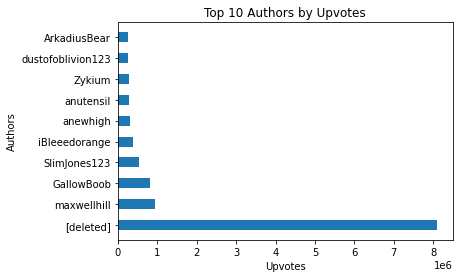

In [40]:
top_10 = ac.most_common(10)
authors, upvotes = [], []
for author, count in top_10:
    authors.append(author)
    upvotes.append(count)
plt.figure()
plt.barh(10*np.arange(len(authors)), upvotes, height=4.8)
plt.yticks(10*np.arange(len(authors)), authors)
plt.title('Top 10 Authors by Upvotes')
plt.xlabel('Upvotes')
plt.ylabel('Authors')
plt.show()

# Authorship Distribution

In [39]:
written_by = Counter()
written_by_dist = {}
k = 'responses'
for i in range(len(train_docs[k])): # Selecting example number
    for j in range(len(train_docs[k][i])): # Selecting response/ancestor number
        curr_dict = train_stats[k][i][j]
        written_by.update({curr_dict['author']: 1})
'''    
for i in range(len(test_docs[k])):
    for j in range(len(test_docs[k][i])):
        curr_dict = test_stats[k][i][j]
        written_by.update({curr_dict['author']: 1})
'''
NUM_POSTS = sum(written_by.values())
NUM_AUTHORS = len(written_by.keys())
#Obtain probability distribution
for author, count in written_by.items():
    written_by_dist[author] = count / NUM_POSTS

print(written_by.most_common(20))

[('[deleted]', 2833), ('mindlessrabble', 99), ('mad-n-fla', 84), ('Chaoslab', 72), ('IrishJoe', 66), ('ivsciguy', 63), ('gonzone', 59), ('JacobCrim88', 51), ('DownvoteDaemon', 51), ('pokemon_fetish', 51), ('pixelwhip', 50), ('EggCouncil', 48), ('tau-lepton', 43), ('TodaysIllusion', 41), ('JumpingJazzJam', 41), ('NeonDisease', 41), ('sleaze_bag_alert', 39), ('Gamer_152', 38), ('duggtodeath', 37), ('Canada_girl', 37)]


In [40]:
print(f'num authors: {NUM_AUTHORS}')
print(f'num posts: {NUM_POSTS}')

num authors: 183249
num posts: 257082


[deleted] accounts for 1.10% of all posts


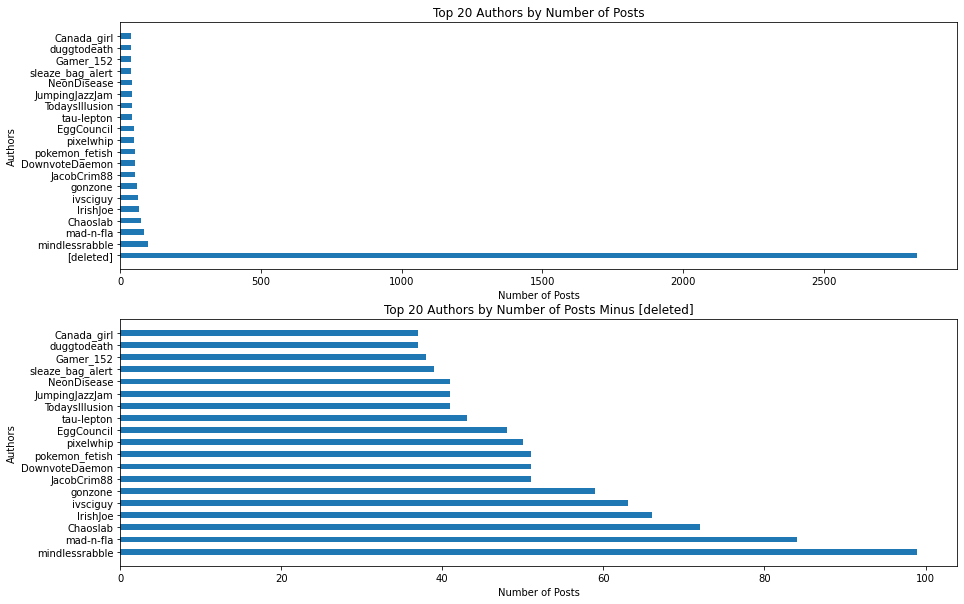

In [41]:
top_20 = written_by.most_common(20)
authors, num_posts = [], []
deleted_posts = written_by['[deleted]']
print(f'[deleted] accounts for {deleted_posts/NUM_POSTS*100:4.2f}% of all posts')
for author, count in top_20:
    authors.append(author)
    num_posts.append(count)
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.barh(10*np.arange(len(authors)), num_posts, height=4.8)
plt.yticks(10*np.arange(len(authors)), authors)
plt.title('Top 20 Authors by Number of Posts')
plt.xlabel('Number of Posts')
plt.ylabel('Authors')

authors = authors[1:]
num_posts = num_posts[1:]
plt.subplot(2, 1, 2)
plt.barh(10*np.arange(len(authors)), num_posts, height=4.8)
plt.yticks(10*np.arange(len(authors)), authors)
plt.title('Top 20 Authors by Number of Posts Minus [deleted]')
plt.xlabel('Number of Posts')
plt.ylabel('Authors')
plt.show()

number of posts 257082
Posts Per Author | Percentage of Posts Covered | Percentage of Authors Covered
01 | 98.90% | 100.00%
02 | 41.66% | 19.70%
03 | 24.19% | 7.44%
04 | 16.21% | 3.71%
05 | 11.76% | 2.15%
06 | 8.99% | 1.38%
07 | 7.07% | 0.93%
08 | 5.73% | 0.66%
09 | 4.81% | 0.50%
10 | 4.03% | 0.37%


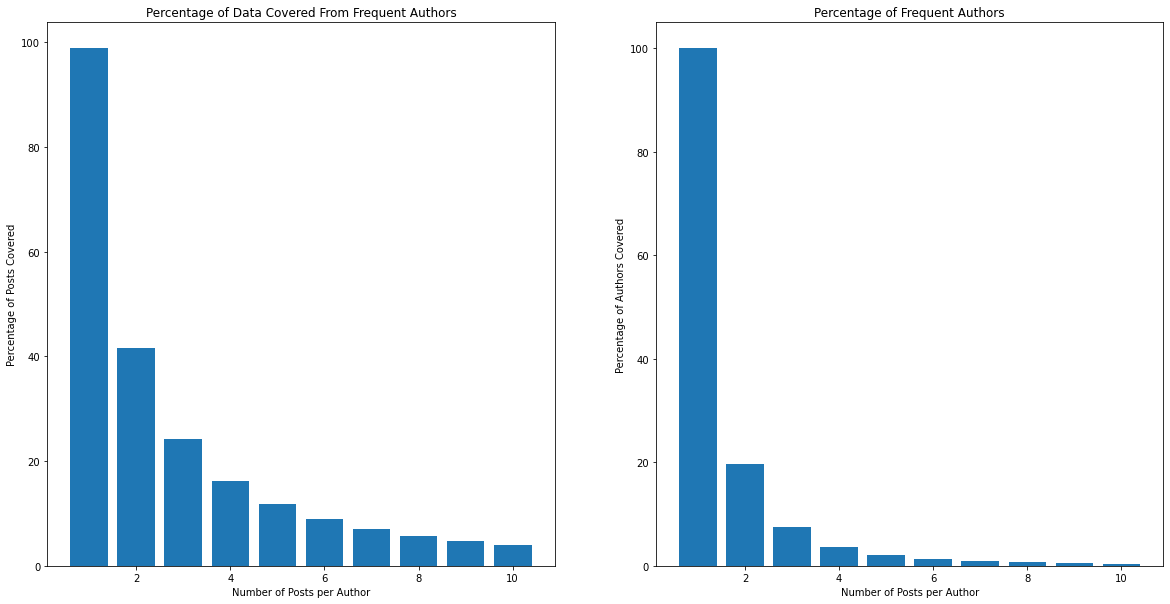

In [47]:
#top_20 = written_by.most_common(20)
percentages = []
authors_accounted = []
num = NUM_POSTS
MAX_POSTS = 11
for sig_post in range(1, MAX_POSTS):
    post_sum = 0
    author_count = 0
    for author, count in written_by.items():
        if author == '[deleted]':
            continue
        if count >= sig_post:
            post_sum += count
            author_count += 1
    authors_accounted.append(author_count / NUM_AUTHORS * 100)
    percentages.append(post_sum / num * 100)
print(f'number of posts {num}')
print('Posts Per Author | Percentage of Posts Covered | Percentage of Authors Covered')
for p in range(len(percentages)):
    print(f'{p+1:02d} | {percentages[p]:04.2f}% | {authors_accounted[p]:04.2f}%')
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.bar(range(1, MAX_POSTS), percentages)
plt.title('Percentage of Data Covered From Frequent Authors')
plt.xlabel('Number of Posts per Author')
plt.ylabel('Percentage of Posts Covered')
plt.subplot(1, 2, 2)
plt.bar(range(1, MAX_POSTS), authors_accounted)
plt.title('Percentage of Frequent Authors')
plt.xlabel('Number of Posts per Author')
plt.ylabel('Percentage of Authors Covered')
plt.show()


# Sarcastic Upvoting

In [8]:
up_sarc, up_nonsarc = [], []
k = 'responses'
for i in range(len(train_docs[k])): # Selecting example number
    for j in range(len(train_docs[k][i])): # Selecting response/ancestor number
        curr_dict = train_stats[k][i][j]
        if int(train_labels[i][j]) == 1:
            up_sarc.append(curr_dict['ups'])
        else:
            up_nonsarc.append(curr_dict['ups'])
print(f'average upvotes for sarcastic: {np.mean(up_sarc)}')
print(f'average upvotes for non-sarcastic: {np.mean(up_nonsarc)}')

average upvotes for sarcastic: 4.6186041807672265
average upvotes for non-sarcastic: 6.309916680281


# Extracting Post-Subreddit Data

In [3]:
train_data, test_data = extract_post_sub(pol=False)

Load SARC data
loading train bal ids
num rows processed 1000
num rows processed 2000
num rows processed 3000
num rows processed 4000
num rows processed 5000
num rows processed 6000
num rows processed 7000
num rows processed 8000
num rows processed 9000
num rows processed 10000
num rows processed 11000
num rows processed 12000
num rows processed 13000
num rows processed 14000
num rows processed 15000
num rows processed 16000
num rows processed 17000
num rows processed 18000
num rows processed 19000
num rows processed 20000
num rows processed 21000
num rows processed 22000
num rows processed 23000
num rows processed 24000
num rows processed 25000
num rows processed 26000
num rows processed 27000
num rows processed 28000
num rows processed 29000
num rows processed 30000
num rows processed 31000
num rows processed 32000
num rows processed 33000
num rows processed 34000
num rows processed 35000
num rows processed 36000
num rows processed 37000
num rows processed 38000
num rows processed 390

In [30]:
with open('train_main_sub.txt', 'w') as outfile:
    json.dump(train_data, outfile)
with open('test_main_sub.txt', 'w') as outfile:
    json.dump(test_data, outfile)

In [34]:
# Get some statistics
from collections import Counter
sub_counts = Counter()
for item in train_data['posts']:
    text, sub = item['text'], item['subreddit']
    sub_counts[sub] += 1

number of posts 6752700
Posts Per Subreddit | Percentage of Posts Covered | Percentage of Subreddits Covered
01 | 100.00% | 100.00%
02 | 100.00% | 96.19%
03 | 99.96% | 77.41%
04 | 99.92% | 66.00%
05 | 99.90% | 58.94%
06 | 99.87% | 54.13%
07 | 99.85% | 50.24%
08 | 99.83% | 47.26%
09 | 99.81% | 45.37%
10 | 99.79% | 43.16%


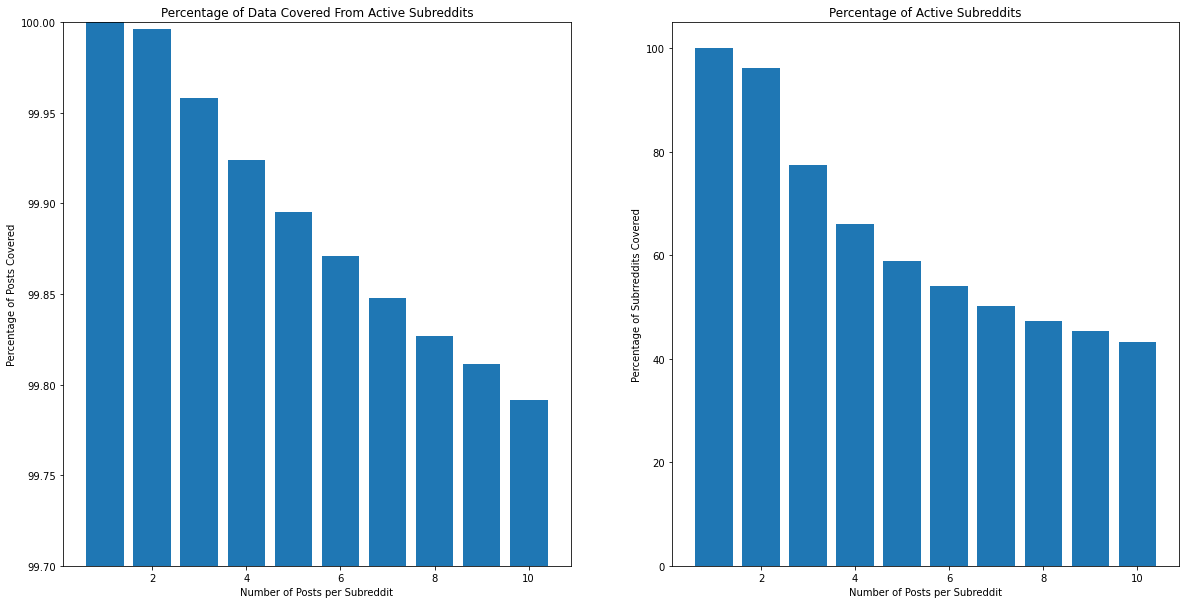

In [46]:
#top_20 = written_by.most_common(20)
percentages = []
subs_accounted = []
num = 6752700
NUM_SUBS=6800
MAX_POSTS = 11
for sig_post in range(1, MAX_POSTS):
    post_sum = 0
    sub_count = 0
    for sub, count in sub_counts.items():
        if count >= sig_post:
            post_sum += count
            sub_count += 1
    subs_accounted.append(sub_count / NUM_SUBS * 100)
    percentages.append(post_sum / num * 100)
print(f'number of posts {num}')
print('Posts Per Subreddit | Percentage of Posts Covered | Percentage of Subreddits Covered')
for p in range(len(percentages)):
    print(f'{p+1:02d} | {percentages[p]:04.2f}% | {subs_accounted[p]:04.2f}%')
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.bar(range(1, MAX_POSTS), percentages)
plt.title('Percentage of Data Covered From Active Subreddits')
plt.xlabel('Number of Posts per Subreddit')
plt.ylabel('Percentage of Posts Covered')
plt.ylim((99.7, 100))
plt.subplot(1, 2, 2)
plt.bar(range(1, MAX_POSTS), subs_accounted)
plt.title('Percentage of Active Subreddits')
plt.xlabel('Number of Posts per Subreddit')
plt.ylabel('Percentage of Subrreddits Covered')
plt.show()

In [54]:
print(sub_counts.most_common(20))

[('AskReddit', 1550163), ('pics', 376878), ('worldnews', 368243), ('politics', 309832), ('videos', 230351), ('news', 228727), ('funny', 227690), ('gaming', 187151), ('WTF', 170284), ('todayilearned', 138980), ('pcmasterrace', 138754), ('AdviceAnimals', 134823), ('gifs', 126471), ('movies', 121505), ('leagueoflegends', 121311), ('The_Donald', 109142), ('nfl', 76135), ('technology', 73732), ('nba', 68027), ('GlobalOffensive', 63306)]


sig post: 10000
sig post: 20000
sig post: 30000
sig post: 40000
sig post: 50000
sig post: 60000
sig post: 70000
sig post: 80000
sig post: 90000
number of posts 6752700
Posts Per Subreddit | Percentage of Posts Covered | Percentage of Subreddits Covered


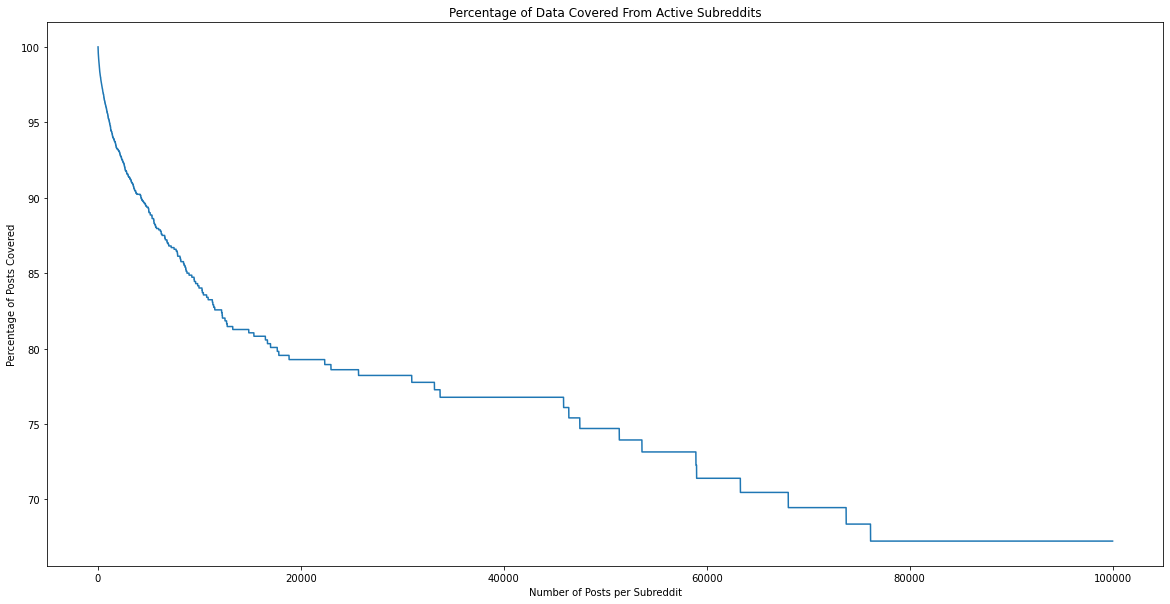

In [62]:
#top_20 = written_by.most_common(20)
percentages = []
subs_accounted = []
num = 6752700
NUM_SUBS=6800
MAX_POSTS = 300000
for sig_post in range(1, MAX_POSTS):
    post_sum = 0
    sub_count = 0
    for sub, count in sub_counts.items():
        if count >= sig_post:
            post_sum += count
            sub_count += 1
    subs_accounted.append(sub_count / NUM_SUBS * 100)
    percentages.append(post_sum / num * 100)
    if sig_post % 10000 == 0:
        print(f'sig post: {sig_post}')
print(f'number of posts {num}')
print('Posts Per Subreddit | Percentage of Posts Covered | Percentage of Subreddits Covered')
#for p in range(len(percentages)):
#    print(f'{p+1:02d} | {percentages[p]:04.2f}% | {subs_accounted[p]:04.2f}%')
plt.figure(figsize=(20, 10))
plt.plot(range(1, MAX_POSTS), percentages)
plt.title('Percentage of Data Covered From Active Subreddits')
plt.xlabel('Number of Posts per Subreddit')
plt.ylabel('Percentage of Posts Covered')
plt.show()


In [57]:
print(subs_accounted[len(subs_accounted) - 1])

0.35294117647058826
